# Create a general MODFLOW model from the NHDPlus dataset

Project specific variables are imported in the model_spec.py and gen_mod_dict.py files that must be included in the notebook directory. The first first includes pathnames to data sources that will be different for each user. The second file includes a dictionary of model-specific information such as  cell size, default hydraulic parameter values, and scenario defintion (e.g. include bedrock, number of layers, etc.). There are examples in the repository. Run the following cells up to the "Run to here" cell to get a pull-down menu of models in the model_dict. Then, without re-running that cell, run all the remaining cells.  Re-running the following cell would re-set the model to the first one in the list, which you probably don't want. If you use the notebook option to run all cells below, it runs the cell you're in, so if you use that option, move to the next cell (below the pull-down menu of models) first.

In [6]:
__author__ = 'Jeff Starn'
%matplotlib notebook
from model_specs import *
from gen_mod_dict import *
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import flopy as fp
import pandas as pd
import gdal
gdal.UseExceptions()
import shutil
# from model_specs import *
# from gen_mod_dict import *

from ipywidgets import interact, Dropdown
from IPython.display import display

In [7]:
for key, value in model_dict.items():
    md = key
    ms = model_dict[md]
    print('trying {}'.format(md))
    try:
        pass
    except:
        pass

trying Oconto
trying Kala2
trying CONN
trying Mani3
trying Whitedam3
trying MO_U16_Mississippi
trying SugarCreek
trying Assabet
trying Tomorrow
trying Board2
trying Racoon
trying Upper_fox
trying NorthSkunk


In [8]:
models = list(model_dict.keys())
models.sort()
model_area = Dropdown(
    options=models,
    description='Model:',
    background_color='cyan',
    border_color='black',
    border_width=2)
display(model_area)

### Run to here to initiate notebook

First time using this notebook in this session (before restarting the notebook), run the cells up to this point. Then select your model from the dropdown list above. Move your cursor to this cell and use the toolbar menu Cell --> Run All Below.  After the first time, if you want to run another model, select your model and start running from this cell--you don't need to re-run the cells from the beginning.

## Preliminary stuff

In [9]:
md = model_area.value
ms = model_dict[md]
print('The model being processed is {}\n'.format(md))

The model being processed is Assabet



Set pathnames and create workspace directories for geographic data (from Notebook 1) and this model.

In [10]:
geo_ws = os.path.join(proj_dir, ms['ws'])
model_ws = os.path.join(geo_ws, scenario_dir)
array_pth = os.path.join(model_ws, 'arrays')
    
try:
    shutil.rmtree(array_pth)
except:
    pass

try:
    shutil.rmtree(model_ws)
except:
    pass

os.makedirs(model_ws)

head_file_name = '{}.hds'.format(md)
head_file_pth = os.path.join(model_ws, head_file_name)

print (model_ws)

C:/General_Models_WRR/subprojects/siteGeneral\Assabet\layers


Replace entries from the default K_dict with the model specific K values from model_dict if they exist. 

In [11]:
for key, value in K_dict.items():
    if key in ms.keys():
        K_dict[key] = ms[key]

Replace entries from the default rock_riv_dict with the model specific values from model_dict if they exist. rock_riv_dict has various attributes of bedrock and stream geometry.

In [12]:
for key, value in rock_riv_dict.items():
    if key in ms.keys():
        rock_riv_dict[key] = ms[key]

Assign values to variables used in this notebook using rock_riv_dict

In [13]:
min_thk = rock_riv_dict['min_thk'] 
stream_width = rock_riv_dict['stream_width'] 
stream_bed_thk = rock_riv_dict['stream_bed_thk']
river_depth = rock_riv_dict['river_depth'] 
bedrock_thk = rock_riv_dict['bedrock_thk']

## Read the information for a model domain processed using Notebook 1

Read the model_grid data frame from a csv file. Extract grid dimensions and ibound array.

In [14]:
model_file = os.path.join(geo_ws, 'model_grid.csv')
model_grid = pd.read_csv(model_file, index_col='node_num', na_values=['nan', hnoflo])

NROW = model_grid.row.max() + 1
NCOL = model_grid.col.max() + 1
num_cells = NROW * NCOL

ibound = model_grid.ibound.reshape(NROW, NCOL)
inactive = (ibound == 0)

C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


## Translate geologic information into hydrologic properties

In [15]:
# # old geology used in general models prior to 4/5/2016
# coarse_deposits = (model_grid.coarse_flag == 2)
# coarse_is_1 = coarse_deposits.reshape(NROW, NCOL)

This version replaces Soller's Surfmat with the Quaternary Atlas. Look-up table for coarse deposits (zone = 1) from Dick Yager's new_unit.  All other categories are lumped with fine deposits (zone = 0).
* alluvium = 1
* ice contact = 9
* lacustrine coarse = 11
* outwash = 17

Create a dictionary that maps the K_dict from gen_mod_dict to zone numbers (key=zone number, value=entry in K_dict).  Make sure these correspond with the correct units. If you're using the defaults, it is correct.

In [16]:
zone_dict = {0 : 'K_fine', 1 : 'K_coarse', 2 : 'K_lakes', 3 : 'K_bedrock'}

Perform the mapping from zone number to K to create the Kh1d array.

In [17]:
zones1d = np.zeros(( NROW, NCOL ), dtype=np.int32)

qa = model_grid.qu_atlas.reshape( NROW, NCOL )
zones1d[qa == 1] = 1
zones1d[qa == 9] = 1
zones1d[qa == 11] = 1
zones1d[qa == 17] = 1

la = model_grid.lake.reshape( NROW, NCOL )
zones1d[la == 1] = 2

Kh1d = np.zeros(( NROW, NCOL ), dtype=np.float32)

for key, val in zone_dict.items():
    Kh1d[zones1d == key] = K_dict[val]
    
model_grid['K0'] = Kh1d.ravel()

C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


## Process boundary condition information

Create a dictionary of stream information for the drain or river package.
River package input also needs the elevation of the river bed. Don't use both packages. The choice is made by commenting/uncommenting sections of the modflow function. Replace segment_len (segment length) with the conductance. The river package has not been tested.

In [18]:
drn_flag = (model_grid.stage != np.nan) & (model_grid.ibound == 1)
drn_data = model_grid.loc[drn_flag, ['lay', 'row', 'col', 'stage', 'segment_len', 'K0']]
drn_data.columns = ['k', 'i', 'j', 'stage', 'segment_len', 'K0']
dcond = drn_data.K0 * drn_data.segment_len * stream_width / stream_bed_thk
drn_data['segment_len'] = dcond
drn_data.rename(columns={'segment_len' : 'cond'}, inplace=True)
drn_data.drop('K0', axis=1, inplace=True)
drn_data.dropna(axis='index', inplace=True)
drn_data.insert(drn_data.shape[1], 'iface', 6)
drn_recarray = drn_data.to_records(index=False)
drn_dict = {0 : drn_recarray}

In [19]:
riv_flag = (model_grid.stage != np.nan) & (model_grid.ibound == 1)
riv_data = model_grid.loc[riv_flag, ['lay', 'row', 'col', 'stage', 'segment_len', 
                                     'reach_intermit', 'K0']]
riv_data.columns = ['k', 'i', 'j', 'stage', 'segment_len', 'rbot', 'K0']
riv_data[['rbot']] = riv_data.stage - river_depth
rcond = riv_data.K0 * riv_data.segment_len * stream_width / stream_bed_thk
riv_data['segment_len'] = rcond
riv_data.rename(columns={'segment_len' : 'rcond'}, inplace=True)
riv_data.drop('K0', axis=1, inplace=True)
riv_data.dropna(axis='index', inplace=True)
riv_data.insert(riv_data.shape[1], 'iface', 6)
riv_recarray = riv_data.to_records(index=False)
riv_dict = {0 : riv_recarray}

Create a dictionary of information for the general-head boundary package.
Similar to the above cell. Not tested.

In [20]:
if model_grid.ghb.sum() > 0:
    ghb_flag = model_grid.ghb == 1
    ghb_data = model_grid.loc[ghb_flag, ['lay', 'row', 'col', 'top', 'segment_len', 'K0']]
    ghb_data.columns = ['k', 'i', 'j', 'stage', 'segment_len', 'K0']
    gcond = ghb_data.K0 * L * L / stream_bed_thk
    ghb_data['segment_len'] = gcond
    ghb_data.rename(columns={'segment_len' : 'cond'}, inplace=True)
    ghb_data.drop('K0', axis=1, inplace=True)
    ghb_data.dropna(axis='index', inplace=True)
    ghb_data.insert(ghb_data.shape[1], 'iface', 6)
    ghb_recarray = ghb_data.to_records(index=False)
    ghb_dict = {0 : ghb_recarray}

### Create 1-layer model to get initial top-of-aquifer on which to drape subsequent layering

Get starting heads from top elevations. The top is defined as the model-cell-mean NED elevation except in streams, where it is interpolated between MaxElevSmo and MinElevSmo in the NHD (called 'stage' in model_grid). Make them a little higher than land so that drains don't accidentally go dry too soon.

In [21]:
top = model_grid.top.reshape(NROW, NCOL)
strt = top * 1.05

C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


Modify the bedrock surface, ensuring that it is always at least min_thk below the top elevation. This calculation will be revisited for the multi-layer case.

In [22]:
bedrock = model_grid.bedrock_el.reshape(NROW, NCOL)
thk = top - bedrock
thk[thk < min_thk] = min_thk
bot = top - thk

C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


## Create recharge array

This version replaces the Wolock/Yager recharge grid with the GWRP SWB grid.

In [23]:
## used in general models prior to 4/5/2016
# rech = model_grid.recharge.reshape(NROW, NCOL)

Replace rech array with
* calculate total recharge for the model domain
* calculate areas of fine and coarse deposits
* apportion recharge according to the ratio specified in gen_mod_dict.py
* write the values to an array

In [24]:
r_swb = model_grid.swb.reshape(NROW, NCOL) / 365.25

rech_ma = np.ma.MaskedArray(r_swb, mask=inactive)
coarse_ma = np.ma.MaskedArray(zones1d != 0, mask=inactive)
fine_ma = np.ma.MaskedArray(zones1d == 0, mask=inactive)

total_rech = rech_ma.sum()
Af = fine_ma.sum()
Ac = coarse_ma.sum()
Rf = total_rech / (rech_fact * Ac + Af)
Rc = rech_fact * Rf

rech = np.zeros_like(r_swb)
rech[zones1d != 0] = Rc
rech[zones1d == 0] = Rf

C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


## Define a function to create and run MODFLOW

In [25]:
def modflow(md, mfpth, model_ws, nlay=1, top=top, strt=strt, nrow=NROW, ncol=NCOL, botm=bedrock, 
            ibound=ibound, hk=Kh1d, rech=rech, stream_dict=drn_dict, delr=L, delc=L, 
            hnoflo=hnoflo, hdry=hdry, iphdry=1):

    strt_dir = os.getcwd()
    os.chdir(model_ws)

    ml = fp.modflow.Modflow(modelname=md, exe_name=mfpth, version='mfnwt', 
                            external_path='arrays') 

    # add packages (DIS has to come before either BAS or the flow package)
    dis = fp.modflow.ModflowDis(ml, nlay=nlay, nrow=NROW, ncol=NCOL, nper=1, delr=L, delc=L, 
                                laycbd=0, top=top, botm=botm, perlen=1.E+05, nstp=1, tsmult=1, 
                                steady=True, itmuni=4, lenuni=2, extension='dis', 
                                unitnumber=11) 

    bas = fp.modflow.ModflowBas(ml, ibound=ibound, strt=strt, ifrefm=True, 
                                ixsec=False, ichflg=False, stoper=None, hnoflo=hnoflo, extension='bas', 
                                unitnumber=13)

    upw = fp.modflow.ModflowUpw(ml, laytyp=1, layavg=0, chani=1.0, layvka=1, laywet=0, ipakcb=53, 
                                hdry=hdry, iphdry=iphdry, hk=hk, hani=1.0, vka=1.0, ss=1e-05, 
                                sy=0.15, vkcb=0.0, noparcheck=False, extension='upw', 
                                unitnumber=31)

    rch = fp.modflow.ModflowRch(ml, nrchop=3, ipakcb=53, rech=rech, irch=1, 
                                extension='rch', unitnumber=19)

    drn = fp.modflow.ModflowDrn(ml, ipakcb=53, stress_period_data=drn_dict, 
                                dtype=drn_dict[0].dtype,
                                extension='drn', unitnumber=21, options=['NOPRINT', 'AUX IFACE'])

    riv = fp.modflow.ModflowRiv(ml, ipakcb=53, stress_period_data=riv_dict, 
                                dtype=riv_dict[0].dtype,
                                extension='riv', unitnumber=18, options=['NOPRINT', 'AUX IFACE'])

    if GHB:
        ghb = fp.modflow.ModflowGhb(ml, ipakcb=53, stress_period_data=ghb_dict, 
                                dtype=ghb_dict[0].dtype,
                                extension='ghb', unitnumber=23, options=['NOPRINT', 'AUX IFACE'])

    oc = fp.modflow.ModflowOc(ml, ihedfm=0, iddnfm=0, chedfm=None, cddnfm=None, cboufm=None, 
                              compact=True, stress_period_data={(0, 0): ['save head', 'save budget']}, 
                              extension=['oc', 'hds', 'ddn', 'cbc'], unitnumber=[14, 51, 52, 53])

#     nwt = fp.modflow.ModflowNwt(ml, headtol=0.0001, fluxtol=500, maxiterout=1000, 
#                                 thickfact=1e-05, linmeth=2, iprnwt=1, ibotav=0, options='COMPLEX')

    nwt = fp.modflow.ModflowNwt(ml, headtol=0.0001, fluxtol=500, maxiterout=100, thickfact=1e-05, 
                                linmeth=2, iprnwt=1, ibotav=1, options='SPECIFIED', dbdtheta =0.80, 
                                dbdkappa = 0.00001, dbdgamma = 0.0, momfact =  0.10, backflag = 1, 
                                maxbackiter=30, backtol=1.05, backreduce=0.4, iacl=2, norder=1, 
                                level=3, north=7, iredsys=1, rrctols=0.0,idroptol=1, epsrn=1.0E-3,
                                hclosexmd= 1.0e-4, mxiterxmd=200)
    
    ml.write_input()
    ml.remove_package('RIV')
    
    ml.write_input()
    success, output = ml.run_model(silent=True)
    os.chdir(strt_dir)
    if success:
        print("    Your {:0d} layer model ran successfully".format(nlay))
    else:
        print("    Your {:0d} layer model didn't work".format(nlay))

## Run 1-layer MODFLOW

Use the function to run MODFLOW for 1 layer to getting approximate top-of-aquifer elevation

In [26]:
modflow(md, mfpth, model_ws, nlay=1, top=top, strt=strt, nrow=NROW, ncol=NCOL, botm=bot, ibound=ibound, 
        hk=Kh1d, rech=rech, stream_dict=drn_dict, delr=L, delc=L, hnoflo=hnoflo, hdry=hdry, iphdry=0)

Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:vani layer 1: resetting 'how' to external
Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:vani layer 1: resetting 'how' to external
    Your 1 layer model ran successfully


Read the head file and calculate new layer top (wt) and bottom (bot) elevations based on the estimated
water table (wt) being the top of the top layer. Divide the surficial layer into NLAY equally thick layers between wt and the bedrock surface elevation (as computed using minimum surficial thickness). 

In [27]:
hdobj = fp.utils.HeadFile(head_file_pth)
heads1 = hdobj.get_data(kstpkper=(0, 0))
heads1[heads1 == hnoflo] = np.nan
heads1[heads1 <= hdry] = np.nan
heads1 = heads1[0, :, :]
hdobj = None

C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in less_equal


## Create layering using the scenario in gen_mod_dict

Make new model with (possibly) multiple layers. If there are dry cells in the 1 layer model, they are converted to NaN (not a number). The minimum function in the first line returns NaN if the element of either input arrays is NaN.  In that case, replace NaN in modeltop with the top elevation. The process is similar to the 1 layer case. Thickness is estimated based on modeltop and bedrock and is constrained to be at least min_thk (set in gen_mod_dict.py). This thickness is divided into num_surf_layers number of layers. The cumulative thickness of these layers is the distance from the top of the model to the bottom of the layers. This 3D array of distances (the same for each layer) is subtracted from modeltop.

In [28]:
modeltop = np.minimum(heads1, top)
nan = np.isnan(heads1)
modeltop[nan] = top[nan]
thk = modeltop - bedrock
thk[thk < min_thk] = min_thk

NLAY = num_surf_layers
lay_extrude = np.ones((NLAY, NROW, NCOL))
lay_thk = lay_extrude * thk / NLAY
bot = modeltop - np.cumsum(lay_thk, axis=0)

C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in minimum
  if __name__ == '__main__':


Using the estimated water table as the new top-of-aquifer elevations sometimes leads to the situation, in usually a very small number of cells, that the drain elevation is below the bottom of the cell.  The following procedure resets the bottom elevation to one meter below the drain elevation if that is the case. 

In [29]:
stg = model_grid.stage.fillna(1.E+30, inplace=False)
tmpdrn = (lay_extrude * stg.reshape(NROW, NCOL)).ravel()
tmpbot = bot.ravel()
index = np.less(tmpdrn, tmpbot)
tmpbot[index] = tmpdrn[index] - 1.0
bot = tmpbot.reshape(NLAY, NROW, NCOL)

C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


* If add_bedrock = True in gen_mod_dict.py, add a layer to the bottom and increment NLAY by 1.
* Assign the new bottom-most layer an elevation equal to the elevation of the bottom of the lowest surficial layer minus bedrock_thk, which is specified in rock_riv_dict (in gen_mod_dict.py).
* Concatenate the new bottom-of-bedrock-layer to the bottom of the surficial bottom array.
* Compute the vertical midpoint of each cell. Make an array (bedrock_index) that is True if the bedrock surface is higher than the midpoint and False if it is not.
* lay_extrude replaces the old lay_extrude to account for the new bedrock layer. It is not used in this cell, but is used later to extrude other arrays.

In [30]:
sol_thk = model_grid.soller_thk.reshape(NROW, NCOL)
tmp = top - sol_thk
bedrock_4_K = bedrock.copy()
bedrock_4_K[bedrock > top] = tmp[bedrock > top]

if add_bedrock:
    NLAY = num_surf_layers + 1
    lay_extrude = np.ones((NLAY, NROW, NCOL))
    bed_bot = bot[-1:,:,:] - bedrock_thk
    bot = np.concatenate((bot, bed_bot), axis=0)

    mids = bot + thk / NLAY / 2
    bedrock_index = mids < bedrock_4_K
    bedrock_index[-1:,:,:] = True

elif not add_bedrock:
    print('    no bedrock')
    pass

else:
    print('    add_bedrock variable needs to True or False')

C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


Extrude all arrays to NLAY number of layers. Create a top-of-aquifer elevation (fake_top) that is higher (20% in this case) than the simulated 1-layer water table because in doing this approximation, some stream elevations end up higher than top_of_aquifer and thus do not operate as drains. The fake_top shouldn't affect model computations if it is set high enough because the model uses convertible (confined or unconfined) layers.

In [31]:
fake_top = (modeltop * 1.2).astype(np.float32)
strt = (lay_extrude * modeltop * 1.05).astype(np.float32)
ibound = (lay_extrude * ibound).astype(np.int16)

Perform the mapping from zone number to K to create the Kh3d array.

In [32]:
zones3d = np.zeros(( NLAY, NROW, NCOL ), dtype=np.int32)

qa = model_grid.qu_atlas.reshape(NROW, NCOL)
qa3d = (lay_extrude * qa).astype(np.int32)

zones3d[qa3d == 1] = 1
zones3d[qa3d == 9] = 1
zones3d[qa3d == 11] = 1
zones3d[qa3d == 17] = 1

if add_bedrock:
    zones3d[bedrock_index] = 3

la = model_grid.lake.reshape(NROW, NCOL)
zones3d[0, la == 1] = 2

Kh3d = np.zeros(( NLAY, NROW, NCOL ), dtype=np.float32)

for key, val in zone_dict.items():
    Kh3d[zones3d == key] = K_dict[val]

C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Run MODFLOW again using the new layer definitions.  The difference from the first run is that the top-of-aquifer elevation is the 1-layer water table rather than land surface, and of course, the number of surficial layers and/or the presence of a bedrock layer is different. 

In [33]:
modflow(md, mfpth, model_ws, nlay=NLAY, top=fake_top, strt=strt, nrow=NROW, ncol=NCOL, 
        botm=bot, ibound=ibound, hk=Kh3d, rech=rech, stream_dict=drn_dict, delr=L, 
        delc=L, hnoflo=hnoflo, hdry=hdry, iphdry=1)

Note: external_path arrays already exists
Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:vani layer 1: resetting 'how' to external
Util2d:vani layer 2: resetting 'how' to external
Util2d:vani layer 3: resetting 'how' to external
Util2d:vani layer 4: resetting 'how' to external
Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:vani layer 1: resetting 'how' to external
Util2d:vani layer 2: resetting 'how' to external
Util2d:vani layer 3: resetting 'how' to external
Util2d:vani layer 4: resetting 'how' to external
    Your 4 layer model ran successfully


Read the new head array

In [34]:
hdobj = fp.utils.HeadFile(head_file_pth)
heads = hdobj.get_data()
hdobj = None

Make a 2D array of the heads in the highest active cells and call it the water_table

In [35]:
heads[heads == hnoflo] = np.nan
heads[heads <= hdry] = np.nan
hin = np.argmax(np.isfinite(heads), axis=0)
row, col = np.indices((hin.shape))
water_table = heads[hin, row, col]

water_table_ma = np.ma.MaskedArray(water_table, inactive)

C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app


Save the head array to a geotiff file.

In [36]:
data = water_table_ma

src_pth = os.path.join(geo_ws, 'ibound.tif')
src = gdal.Open(src_pth)

dst_pth = os.path.join(model_ws, 'pre-heads.tif')
driver = gdal.GetDriverByName('GTiff')
dst = driver.CreateCopy(dst_pth, src, 0)

band = dst.GetRasterBand(1)
band.WriteArray(data)
band.SetNoDataValue(np.nan)

dst = None
src = None

Save the heads and K from the upper-most layer to model_grid.csv

In [37]:
model_grid['pre_cal_heads'] = water_table_ma.ravel()
model_grid['pre_cal_K'] = Kh3d[0,:,:].ravel()

if add_bedrock:
    model_grid['thk'] = model_grid.top - bot[-1,:,:].ravel() + bedrock_thk
else:
    model_grid['thk'] = model_grid.top - bot[-1,:,:].ravel()

model_grid['thkR'] = model_grid.thk / model_grid.recharge
    
model_grid.to_csv(os.path.join(model_ws, 'model_grid.csv'))

Save zone array for use in calibration.

In [38]:
zone_file = os.path.join(model_ws, 'zone_array.npz')
np.savez(zone_file, zone=zones3d)

Plot a cross-section to see what the layers look like.  Change row_to_plot to see other rows.  Columns could be easily added.

In [39]:
def calc_error(top, head, obs_type):
    # an offset of 1 is used to eliminate counting heads that
    # are within 1 m of their target as errors.
    # count topo and hydro errors
    t = top < (head - err_tol)
    h = top > (head + err_tol)

    tmp_df = pd.DataFrame({'head':head, 'ot':obs_type, 't':t, 'h':h})

    tmp = tmp_df.groupby('ot').sum()
    h_e_ = tmp.loc['hydro', 'h']
    t_e_ = tmp.loc['topo', 't']
    result = np.array([h_e_, t_e_])
    return result

In [40]:
hydro, topo = calc_error(model_grid.top, water_table.ravel(), model_grid.obs_type)
num_hydro = model_grid.obs_type.value_counts()['hydro']
num_topo = model_grid.obs_type.value_counts()['topo']
num_cells = num_hydro + num_topo
hydro = hydro / num_hydro
topo = topo / num_topo

<IPython.core.display.Javascript object>


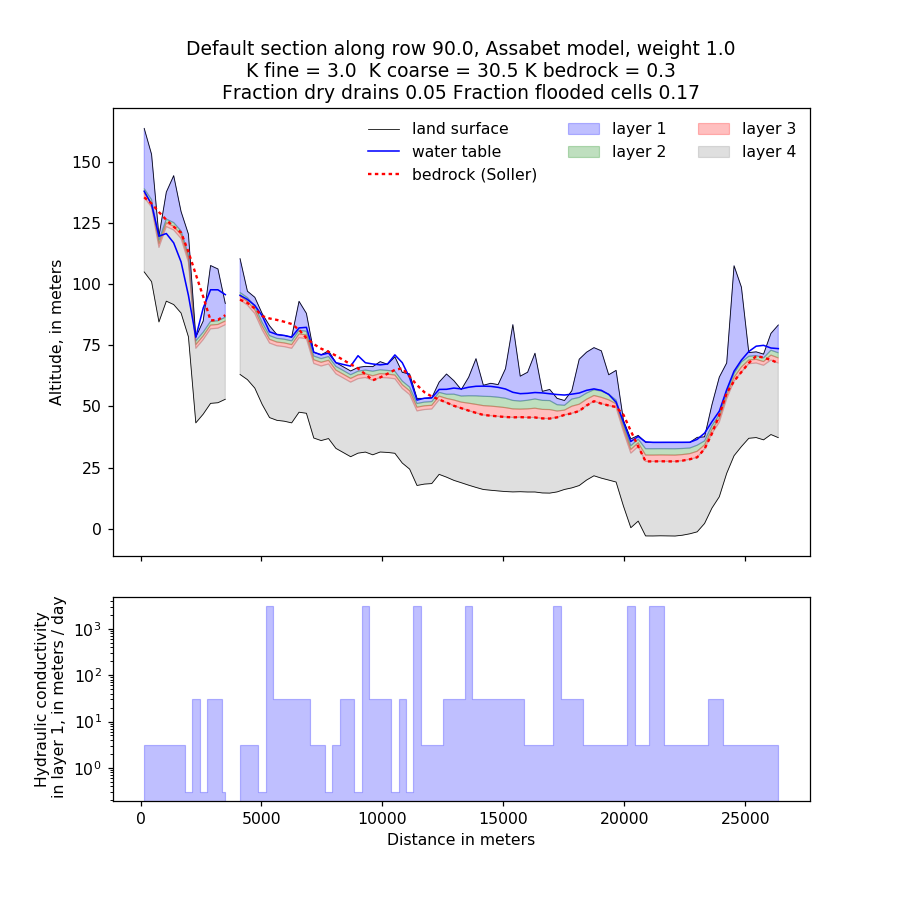

C:\Miniconda2\envs\myenvironment\lib\site-packages\numpy\ma\core.py:3158: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
C:\Miniconda2\envs\myenvironment\lib\site-packages\numpy\ma\core.py:3213: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]


In [41]:
def ma2(data2D):
    return np.ma.MaskedArray(data2D, mask=inactive)

def ma3(data3D):
    return np.ma.MaskedArray(data3D, mask=(ibound == 0))

row_to_plot = NROW / 2
xplot = np.linspace( L / 2, NCOL * L - L / 2, NCOL)

mKh = ma3(Kh3d)
mtop = ma2(top)
mbed = ma2(bedrock)
mbot = ma3(bot)

colors = ['green', 'red', 'gray']

fig = plt.figure(figsize=(8,8))

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

ax1.plot(xplot, mtop[row_to_plot, ], label='land surface', color='black', lw=0.5)
ax1.plot(xplot, water_table_ma[row_to_plot, ], label='water table', color='blue', lw=1.)
ax1.fill_between(xplot, mtop[row_to_plot, ], mbot[0, row_to_plot, :], alpha=0.25, 
                 color='blue', label='layer 1', lw=0.75)
for lay in range(NLAY-1):
    label = 'layer {}'.format(lay+2)
    ax1.fill_between(xplot, mbot[lay, row_to_plot, :], mbot[lay+1, row_to_plot, :], label=label, 
                    color=colors[lay], alpha=0.250, lw=0.75)
ax1.plot(xplot, mbed[row_to_plot, :], label='bedrock (Soller)', color='red', linestyle='dotted', lw=1.5)
ax1.plot(xplot, mbot[-1, row_to_plot, :], color='black', linestyle='solid', lw=0.5)
ax1.legend(loc=0, frameon=False, fontsize=10, ncol=3)#, bbox_to_anchor=(1.0, 0.5))
ax1.set_ylabel('Altitude, in meters')
ax1.set_xticklabels('')
ax1.set_title('Default section along row {}, {} model, weight {:0.1f}\nK fine = {:0.1f}  K coarse = {:0.1f}\
 K bedrock = {:0.1f}\nFraction dry drains {:0.2f} Fraction flooded cells {:0.2f}'.format(row_to_plot, \
 md, 1,  K_dict['K_fine'], K_dict['K_coarse'], K_dict['K_bedrock'], hydro, topo))

ax2 = plt.subplot2grid((3, 1), (2, 0))
ax2.fill_between(xplot, 0, mKh[0, row_to_plot, :], alpha=0.25, color='blue', 
                 label='layer 1', lw=0.75, step='mid')
ax2.set_xlabel('Distance in meters')
ax2.set_yscale('log')
ax2.set_ylabel('Hydraulic conductivity\n in layer 1, in meters / day')

line = '{}_{}_xs.png'.format(md, scenario_dir)
fig_name = os.path.join(model_ws, line)
plt.savefig(fig_name)

In [42]:
t = top < (water_table - err_tol)
h = top > (water_table + err_tol)

mt = np.ma.MaskedArray(t.reshape(NROW, NCOL), model_grid.obs_type != 'topo')
mh = np.ma.MaskedArray(h.reshape(NROW, NCOL), model_grid.obs_type != 'hydro')

C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
C:\Miniconda2\envs\myenvironment\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


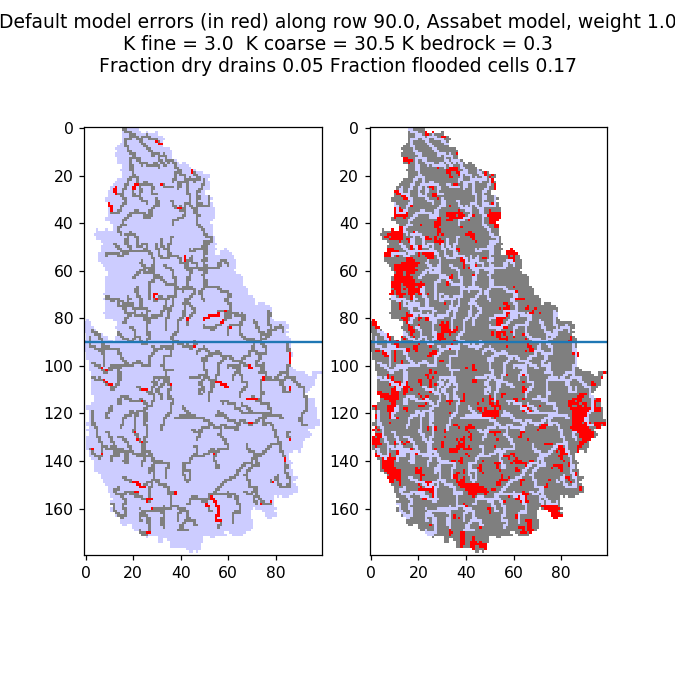

In [43]:
from matplotlib import colors

cmap = colors.ListedColormap(['0.50', 'red'])
cmap2 = colors.ListedColormap(['blue'])

back = np.ma.MaskedArray(ibound[0,:,:], ibound[0,:,:] == 0)
fig, ax = plt.subplots(1,2)
ax[0].imshow(back, cmap=cmap2, alpha=0.2)
im0 = ax[0].imshow(mh, cmap=cmap, interpolation='None')
ax[0].axhline(row_to_plot)
# fig.colorbar(im0, ax=ax[0])
ax[1].imshow(back, cmap=cmap2, alpha=0.2)
im1 = ax[1].imshow(mt, cmap=cmap, interpolation='None')
ax[1].axhline(row_to_plot)
# fig.colorbar(im1, ax=ax[1])
fig.suptitle('Default model errors (in red) along row {}, {} model, weight {:0.1f}\nK fine = {:0.1f}  K coarse = {:0.1f}\
 K bedrock = {:0.1f}\nFraction dry drains {:0.2f} Fraction flooded cells {:0.2f}'.format(row_to_plot, \
 md, 1.0, K_dict['K_fine'], K_dict['K_coarse'], K_dict['K_bedrock'], hydro, topo))

# fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
#                       wspace=None, hspace=None)

fig.set_size_inches(6, 6)

# line = '{}_{}_error_map_cal.png'.format(md, scenario_dir)
line = '{}_{}_error_map.png'.format(md, scenario_dir)   #csc
fig_name = os.path.join(model_ws, line)
plt.savefig(fig_name)